In [ ]:
! pip install datasets >> /dev/null

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from datasets import load_dataset
from IPython.display import display

In [ ]:
ds = load_dataset('microsoft/cats_vs_dogs')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.16k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

In [ ]:
ds.shape

{'train': (23410, 2)}

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

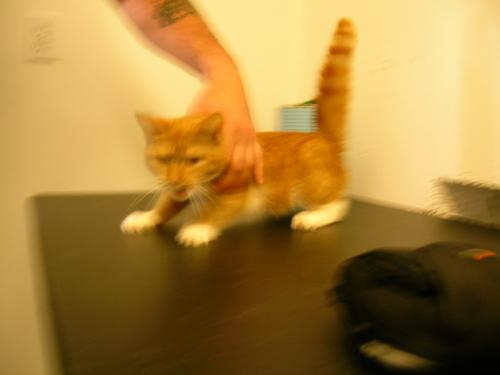

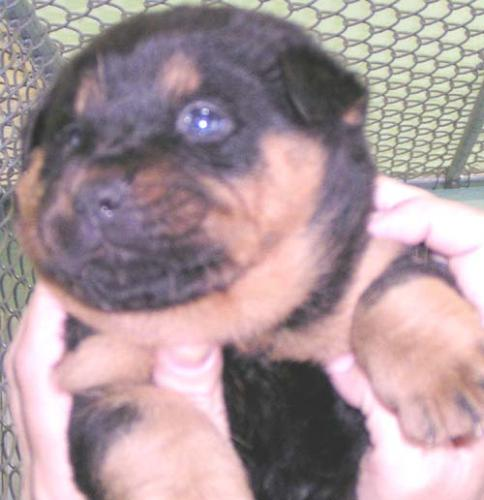

In [ ]:
display(ds["train"][0]["image"])
display(ds["train"][23400]["image"])

In [ ]:
import concurrent.futures
import numpy as np
import pandas as pd
from PIL import ImageOps
from PIL import Image

def get_image_shape(img) -> tuple:
    img = np.array(img)
    return img.shape

def get_the_max_min_x_y_values(dataset) -> tuple:
    # Parallel computation of image shapes
    with concurrent.futures.ThreadPoolExecutor() as executor:
        shapes = list(executor.map(get_image_shape, dataset["image"]))

    # Compute the max shape across all images
    max_x = max(shapes, key=lambda s: s[0])[0]
    max_y = max(shapes, key=lambda s: s[1])[1]
    return max_x, max_y

def preprocess_entry(image, classname, max_x, max_y):
    image = Image.fromarray(np.array(image))
    image = ImageOps.pad(image, (max_y, max_x), color=(0,))  # Padding to (width, height)
    if image.mode != 'RGB':
        image = image.convert('RGB')  # Ensure the image is in RGB mode
    image = ImageOps.pad(image, (max_y, max_x), color=(0, 0, 0))  # Padding with
    image = np.array(image)  # Convert back to NumPy array
    return (image, classname)


def preprocess_dataset(dataset) -> pd.DataFrame:
    # max_x, max_y = get_the_max_min_x_y_values(dataset)
    max_x, max_y = 500, 500
    # Pass max_x and max_y as lists to repeat their values for each entry
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = list(executor.map(preprocess_entry, dataset["image"],
                                    dataset["labels"],
                                    [max_x] * len(dataset["image"]),
                                    [max_y] * len(dataset["image"])))

    # Convert results into a pandas DataFrame
    df = pd.DataFrame(results, columns=["image", "labels"])
    return df


In [ ]:
data = preprocess_dataset(ds["train"])

In [ ]:
data.head()

,image,labels
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
4,"[[[133, 107, 70], [133, 107, 70], [134, 107, 7...",0
...,...,...
23405,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
23406,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
23407,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
23408,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
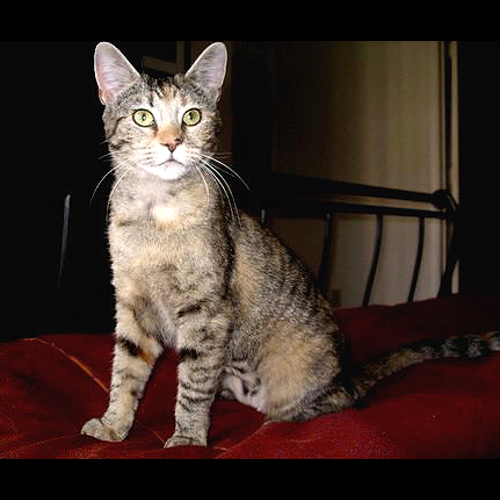

In [ ]:
data.iloc[5]["image"]

In [ ]:
data.to_csv("data.csv")